# Experiments with LoRa Dreambooth

Tested on a Colab T4 instance. Just run all cells sequentially to reproduce results.

In [ ]:
# @title Download and install requirements

# Install diffusers and fix the version
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!git checkout c4d282360184686f7d4a66787a4be9898cf1b8b0
# !pip install -e .
!pip install .

# Install LoRa for Dreambooth requirements
%cd examples/dreambooth/
!pip install -r requirements.txt
%cd ../../..

# Get the data
!git clone https://github.com/axchizhov/kabina_spyachky
%cd kabina_spyachky

# Misc
!pip install wandb bitsandbytes xformers

# Setup
import accelerate

accelerate.utils.write_basic_config()

In [ ]:
# @title Set the hyperparameters

# @markdown #### General settings
model_name = "stabilityai/stable-diffusion-2-1" # @param {type:'string'}
output_dir = "output" # @param {type:'string'}
resolution = 768 # @param {type:'number'}
epochs = 300 # @param {type:'number'}
train_batch_size = 1 # @param {type:'number'}


# @markdown #### Subject
reference_subject_dir = "/content/kabina_spyachky/Mathilda/small_same_clothes_cardigan_768" # @param {type:'string'}
subject_prompt = "a photo of sks girl" # @param {type:'string'}
validation_prompt = "A photo of sks girl with a glock" # @param {type:'string'}


# @markdown #### Prior preservation
class_preservation_prompt="a photo of a girl" # @param {type:'string'}
generate_class_preservation_samples = 200 # @param {type:'number'}
prior_loss_weight = 1.0 # @param {type:'number'}


# @markdown #### Monitoring with W&B
login_into_wandb = False # @param {type:"boolean"}
# wandb_project_name = "kabina_spyachky" # @param {type:'string'}
# wandb_notes = "" # @param {type:'string'}
# wandb_tag = "" # @param {type:'string'}
if login_into_wandb:
    import wandb
    wandb.login()

/content/kabina_spyachky/Mathilda/small_same_clothes_cardigan_768


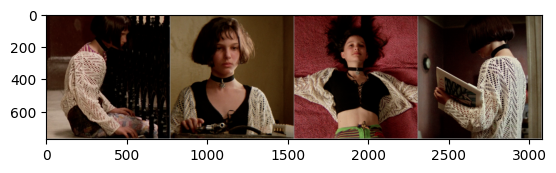

In [ ]:
# @title Dispaly reference suject images
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

image_paths = Path(reference_subject_dir).glob("*.png")

resize_transform = transforms.Compose([
    transforms.Resize((resolution, resolution)),
    transforms.ToTensor()
])

images = [resize_transform(Image.open(path)) for path in image_paths]
grid = make_grid(images)
img = transforms.ToPILImage()(grid)
plt.imshow(img)
print(reference_subject_dir)

In [ ]:
# @title Run the experiment

script = "../diffusers/examples/dreambooth/train_dreambooth_lora.py"
steps = int(epochs * len(images) / train_batch_size)

!accelerate launch --mixed_precision=fp16 $script \
  --pretrained_model_name_or_path=$model_name  \
  --instance_data_dir=$reference_subject_dir \
  --output_dir=$output_dir \
  --instance_prompt="$subject_prompt" \
  --resolution=$resolution \
  --train_batch_size=$train_batch_size \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$steps \
  --validation_prompt="$validation_prompt" \
  --validation_epochs=10 \
  --seed="42" \
  --enable_xformers_memory_efficient_attention

  # --report_to="wandb"

  # --class_prompt="$class_preservation_prompt" \
  # --with_prior_preservation \
  # --prior_loss_weight=$prior_loss_weight \
  # --num_class_images=$generate_class_preservation_samples \
  # --sample_batch_size=4 \
  # --class_data_dir="class_preservation_samples"
  # --use_8bit_adam
  # --gradient_accumulation_steps=2 --gradient_checkpointing \

In [ ]:
#@title Setup inference

import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

pipe = DiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float16, use_safetensors=True)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")
pipe.unet.load_attn_procs(output_dir)

In [ ]:
# @title Play with the model
inference_prompt = 'A photo of a sks girl' #@param {type:"string"}
guidance_scale = 1.5 #@param {type:"slider", min:0, max:15, step:0.2}

image = pipe(inference_prompt, num_inference_steps=25, guidance_scale=1.5).images[0]
image